In [ ]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """빈 상태-행동 가치(state-action values, q_values) 딕셔너리와 학습률, 엡실론 값을 가진 강화학습 에이전트를 초기화합니다.

        Args:
            env: 훈련 환경
            learning_rate: 학습률
            initial_epsilon: 초기 엡실론 값
            epsilon_decay: 엡실론 감소율
            final_epsilon: 최종 엡실론 값
            discount_factor: Q-가치를 계산하기 위한 할인율 (기본값: 0.95)
        """
        self.env = env  # 환경 저장
        # Q-가치 테이블을 defaultdict로 초기화, 기본값은 행동 수만큼의 0 배열
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate  # 학습률 저장
        self.discount_factor = discount_factor  # 할인율 저장

        self.epsilon = initial_epsilon  # 초기 엡실론 값
        self.epsilon_decay = epsilon_decay  # 엡실론 감소율
        self.final_epsilon = final_epsilon  # 최종 엡실론 값

        self.training_error = []  # 훈련 중 발생하는 시간차(TD) 오차를 저장할 리스트

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        (1 - 엡실론) 확률로 최적의 행동을 반환하고,
        엡실론 확률로 랜덤 행동을 반환하여 탐색을 보장합니다.
        """
        # 엡실론 확률로 환경을 탐색하기 위해 랜덤 행동 반환
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # (1 - 엡실론) 확률로 그리디하게 행동(활용)
        else:
            return int(np.argmax(self.q_values[obs]))  # Q-가치가 가장 높은 행동 선택

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """행동의 Q-가치를 업데이트합니다."""
        # 종료되지 않았다면 다음 상태의 최대 Q-가치 사용, 종료 시 0
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        # 시간차(TD) 계산: 보상 + 할인된 미래 가치 - 현재 Q-가치
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        # Q-가치 업데이트: 현재 Q-가치 + 학습률 * 시간차
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)  # 시간차 오차 기록

    def decay_epsilon(self):
        # 엡실론을 감소시키되, 최종 엡실론 값 아래로 내려가지 않도록 설정
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


# 하이퍼파라미터
learning_rate = 0.01 # 학습률
n_episodes = 100_000  # 총 에피소드 수
start_epsilon = 1.0  # 초기 엡실론 값 (100% 탐색)
epsilon_decay = start_epsilon / (n_episodes / 2)  # 시간에 따라 탐색을 줄이기 위한 감소율
final_epsilon = 0.1  # 최종 엡실론 값 (10% 탐색)

env = gym.make("Blackjack-v1", sab=False)  # Blackjack-v1 환경 생성, sab=False로 기본 룰 사용
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)  # 에피소드 통계 기록 Wrapper 추가

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

from tqdm import tqdm  # 진행 상황을 보기 위한 라이브러리

for episode in tqdm(range(n_episodes)):  # 진행률 표시와 함께 에피소드 반복
    obs, info = env.reset()  # 환경 초기화
    done = False  # 종료 여부 플래그

    # 한 에피소드 플레이
    while not done:
        action = agent.get_action(obs)  # 현재 관찰값으로 행동 선택
        next_obs, reward, terminated, truncated, info = env.step(action)  # 행동 실행

        # 에이전트 업데이트
        agent.update(obs, action, reward, terminated, next_obs)

        # 환경 종료 여부와 현재 관찰값 업데이트
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()  # 에피소드 끝날 때마다 엡실론 감소

100%|██████████| 1000000/1000000 [01:08<00:00, 14586.15it/s]


/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 그래프 간격 조정
/tmp/ipykernel_1988/4182213820.py:42: UserWarning: Glyph 44600

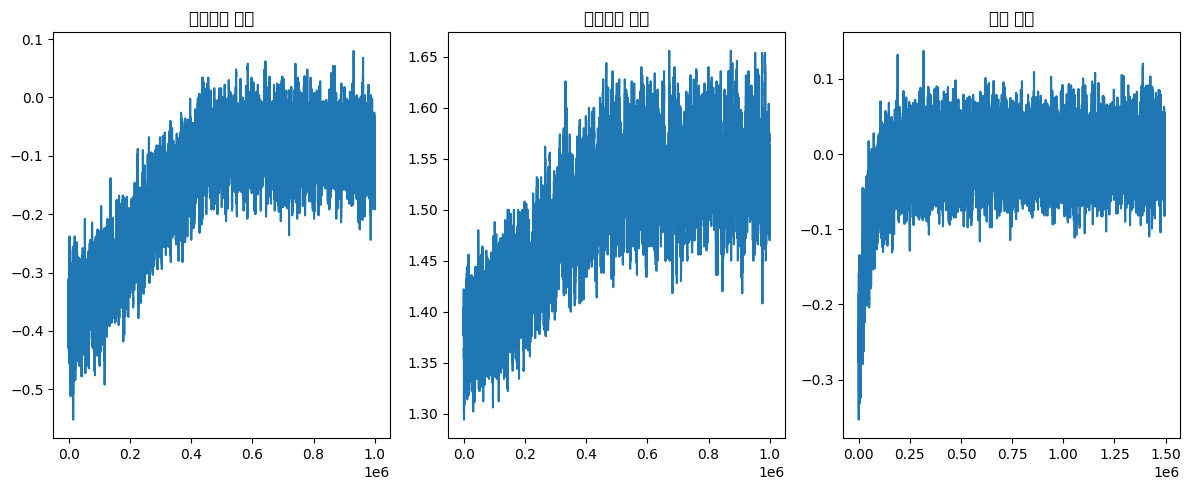

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    # 이동 평균 계산 함수
    return np.convolve(
        np.array(arr).flatten(),  # 배열 평평하게
        np.ones(window),  # 이동 평균 창 크기
        mode=convolution_mode  # 컨볼루션 모드
    ) / window

# 500 에피소드 창으로 평활화
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))  # 3개의 그래프를 가로로 배치

# 에피소드 보상 그래프
axs[0].set_title("에피소드 보상")
reward_moving_average = get_moving_avgs(
    env.return_queue,  # 기록된 보상 큐
    rolling_length,
    "valid"  # 유효한 범위만 계산
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# 에피소드 길이 그래프
axs[1].set_title("에피소드 길이")
length_moving_average = get_moving_avgs(
    env.length_queue,  # 기록된 길이 큐
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# 훈련 오차 그래프
axs[2].set_title("훈련 오차")
training_error_moving_average = get_moving_avgs(
    agent.training_error,  # 시간차 오차 리스트
    rolling_length,
    "same"  # 원래 길이 유지
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()  # 그래프 간격 조정
plt.show()